In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import doctest
import copy

In [3]:
#https://stackoverflow.com/questions/40137950/possible-to-run-python-doctest-on-a-jupyter-cell-function
def test(func):
    '''
    Use test as a decorator to a function with doctests in Jupyter notebook. 
    Run the cell to see the results of the doctests.
    '''
    globs = copy.copy(globals())
    globs.update({func.__name__:func})
    doctest.run_docstring_examples(func, globs, verbose=True, name=func.__name__)
    return func

### Simulate straight line and circular movements with Bicycle model

Robot is at the origin (0, 0) and facing North, i.e, $\theta = \pi/2$. Assume the wheelbase of the vehicle $L$ = 0.9 m

In [4]:
#@test 
def bicycle_model(curr_pose, v, delta, dt=1.0):
    '''
    >>> bicycle_model((0.0,0.0,0.0), 1.0, 0.0)
    (1.0, 0.0, 0.0)
    >>> bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
    (0.0, 0.0, 0.0) 
    >>> bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4)
    (1.0, 0.0, 1.11) 
    '''
    
    # write code to calculate next_pose
    # refer to the kinematic equations of a bicycle model
    x, y, theta = curr_pose
    x = curr_pose[0] + v*np.cos(curr_pose[2])*dt
    y = curr_pose[1] + v*np.sin(curr_pose[2])*dt
    theta = curr_pose[2] + v*np.tan(delta)/0.9
    
    # Keep theta bounded between [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))
    # return calculated (x, y, theta)
    return x, y, theta

In [5]:
#straight line
straight_trajectory = []
pose = (0, 0, np.pi/2)
steps = 10
#fill in v and delta values
all_v = np.ones(steps)
all_delta = np.zeros(steps)
for v, delta in zip(all_v, all_delta): 
      straight_trajectory.append(pose)
      pose = bicycle_model(pose, v, delta)
straight_trajectory = np.array(straight_trajectory)
   
    

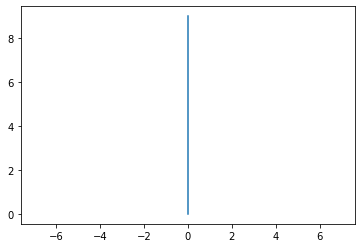

In [6]:
## plot for straight line
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(straight_trajectory[:,0], straight_trajectory[:,1])
plt.show()

In [7]:
#circle
circular_trajectory = []
pose = (0, 0, np.pi/2)
steps = 10
#fill in v and delta values
all_v = 0.01*np.ones(steps*100)
all_delta = np.ones(steps*100) 
for v, delta in zip(all_v, all_delta):
   # store pose
   circular_trajectory.append(pose)
   #instruction to take v, w and compute new pose    
   pose = bicycle_model(pose, v, delta,0.1)
circular_trajectory = np.array(circular_trajectory)


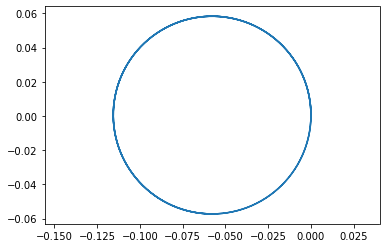

In [8]:
### Plot for circular trajectories
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(circular_trajectory[:,0], circular_trajectory[:,1])
plt.show()


### Simulate Bicycle model with Open Loop control

We want the robot to follow these instructions

**straight 10m, right turn, straight 5m, left turn, straight 8m, right turn**

It is in open loop; control commands have to be calculated upfront. How do we do it?

To keep things simple in the first iteration, we can fix $v = v_c$ and change only $\delta$. To make it even simpler, $\delta$ can take only 2 values 
+ 0 when the vehicle is going straight 
+ $\delta = \delta_c$ when turning

This leaves only 2 questions to be answered
* What should be $v_c$ and $\delta_c$?
* When should $\delta$ change from 0 and back?

In [47]:
vc = 0.9 #m/s
deltac = (np.pi/6) #rad/s

#calculate time taken to finish a quarter turn (pi/2)
# unlike you would need to take into account v_c and L of the vehicle as well
t_turn = int((np.pi/2)*0.9/v*np.tan(delta) +0.9/vc) 

#calculate the time taken to finish straight segments
# omega array is to be padded with equivalent zeros

t_straight1, t_straight2, t_straight3 = int(10.0/vc), int(5.0/vc), int(8.0/vc)
all_delta = [0]*t_straight1 + [deltac]*t_turn + \
        [0]*t_straight2 + [deltac]*t_turn + \
        [0]*t_straight3 + [-deltac]*t_turn

all_v = vc*np.ones_like(all_delta)

Let us make a cool function out of this!

Take in as input a generic route and convert it into open-loop commands

Input format: [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]

Output: all_v, all_delta

In [48]:
def get_open_loop_commands(route, vc_slow=0.5,vc_fast=1, deltac=np.pi/12,dt=1.0):
    all_delta = []
    deltas = {'straight': 0, 'left': deltac, 'right': -deltac}  
    for manoeuvre, command in route:
      u = np.ceil(command/vc).astype('int')
      v = np.ceil(np.deg2rad(command)/deltac).astype('int')
      t_cmd = u if manoeuvre == 'straight' else v
      all_delta += [deltas[manoeuvre]]*t_cmd
      all_v = vc*np.ones_like(all_delta)
    return all_v, all_delta

### Unit test your function with the following inputs

+ [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]
+ $v_c = 1$
+ $delta_c = \pi/12$

In [49]:
all_v, all_delta = get_open_loop_commands([("straight", 5), ("right", 90), ("straight", 6), ("left", 85)])

In [50]:
robot_trajectory = []
all_v, all_delta = get_open_loop_commands([("straight", 5), ("right", 90), ("straight", 6), ("left", 85)])
pose = np.array([0, 0, np.pi/2])
for v, delta in zip(all_v, all_delta): 
      robot_trajectory.append(pose)
      pose = bicycle_model(pose, v, delta,0.1)
robot_trajectory = np.array(robot_trajectory)
    

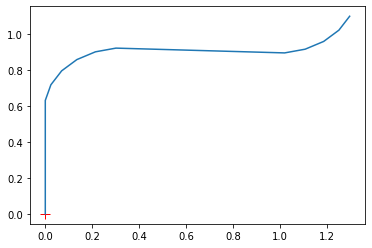

In [51]:
# plot robot trajectory
plt.figure()

plt.plot( )

#show first and last robot positions with + markers
xi, yi, _ = robot_trajectory[0]
xf, yf, _ = robot_trajectory[-1]
plt.plot(xi,yi,'r+',ms=10)
plt.plot(robot_trajectory[:,0], robot_trajectory[:,1])
plt.show()


### Shape the turn
Let us try something cooler than before (though a bit tricky in open loop). Instead of boring circular arcs, change the steering angle so that the robot orientation changes as shown in the equation below

$\theta = (\theta_i - \theta_f) * (1 - 3x^2 + 2\theta^3) + \theta_f  \thinspace \vee x \in [0,1]$

First let us plot this

In [ ]:
def poly_turn(theta_i, theta_f, n=10):
    x = np.linspace(0, 1, num=n)
    return (theta_i-theta_f) * (1 - 3 * x * x + 2 * (x**3)) + theta_f

How does a right turn look? 

In [ ]:
theta_dot = np.diff(poly_turn(np.pi/2, 0))
print(theta_dot)

[-0.05386819 -0.14436674 -0.20900856 -0.24779366 -0.26072202 -0.24779366
 -0.20900856 -0.14436674 -0.05386819]


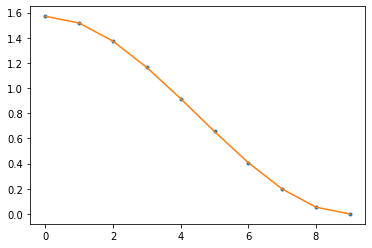

In [ ]:
plt.figure()
plt.plot(poly_turn(np.pi/2, 0),'.')
plt.plot(poly_turn(np.pi/2, 0))

Now plot a left turn (North to East)

In [ ]:
theta_dot = np.diff(poly_turn(0,np.pi/2))
print(theta_dot)

[0.05386819 0.14436674 0.20900856 0.24779366 0.26072202 0.24779366
 0.20900856 0.14436674 0.05386819]


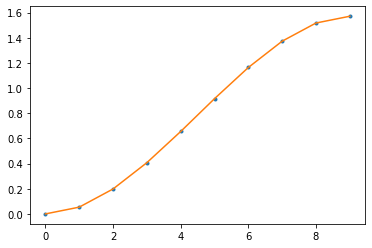

In [ ]:
plt.figure()
plt.plot(poly_turn(0,np.pi/2),'.')
plt.plot(poly_turn(0,np.pi/2))



How does $\theta$ change when we had constant $\delta$? Plot it

We know the rate of change of $\theta$ is proportional to $\delta$. Can you work out the sequence of $\delta$ to change $\theta$ as in the cubic polynomial shown above?